<a href="https://colab.research.google.com/github/OmniaOsama03/Transaction-Type-Prediction/blob/main/Transaction_Type_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_validate, train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import GradientBoostingClassifier
!pip install h2o
import h2o
h2o.init()
from h2o.estimators import H2ORandomForestEstimator




# Setting up visualization
%matplotlib inline
sns.set(color_codes=True)

# Loading data
df = pd.read_csv('/content/metaverse_transactions_dataset.csv')
df = df.drop(columns=['timestamp', 'sending_address', 'receiving_address'])


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.6/265.6 MB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.46.0.5-py2.py3-none-any.whl size=265646558 sha256=6cc976114095d556cafb19f83e48cd490a69bef98d3932f5aefa963fffa50820
  Stored in directory: /root/.cache/pip/wheels/1a/46/4f/9b366522399306d7849672d58aefb44c9b73378d710bde2853
Successfully built h2o
Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.24" 2024-07-16; OpenJDK Runtime Environment (build 11.0.24+8-post-Ubuntu-1ubuntu322.04); OpenJDK 64-Bit Server VM (build 11.0.24+8-post-Ubuntu-1ubuntu322.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp0590693g
  JVM stdout: /tmp/tmp0590693g/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp0590693g/h2o_unknownUser_started

H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,2 months
H2O_cluster_name:,H2O_from_python_unknownUser_ichssj
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# Calculate and print the descriptive statistics
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

stats_summary = df[numeric_columns].describe().T[['mean', '50%', 'std']]
stats_summary.rename(columns={'50%': 'median'}, inplace=True)
print(stats_summary)


                        mean    median         std
hour_of_day        11.532634   12.0000    6.935897
amount            502.574903  500.0295  245.898146
ip_prefix         147.644430  172.1600   69.388143
login_frequency     4.178702    4.0000    2.366038
session_duration   69.684606   60.0000   40.524476
risk_score         44.956722   40.0000   21.775365


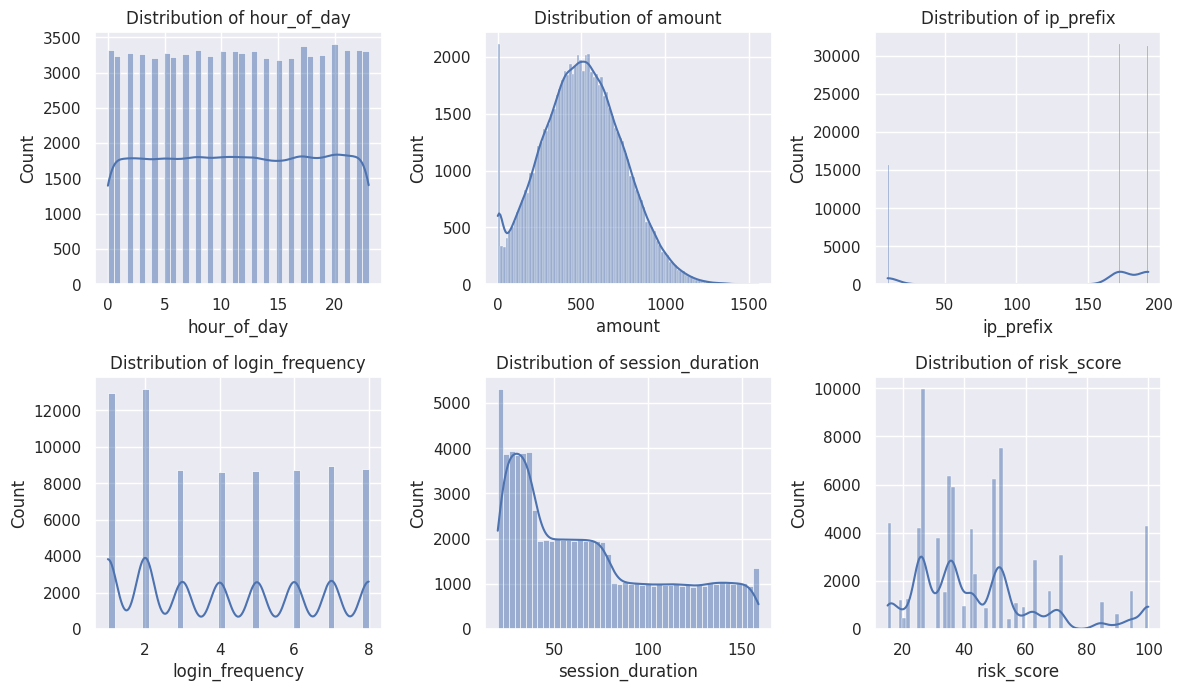

In [ ]:
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
# Visualizing distributions of numeric features with histograms
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(12, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)  # Adjust the number of rows/cols based on the number of features
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.tight_layout()

plt.show()


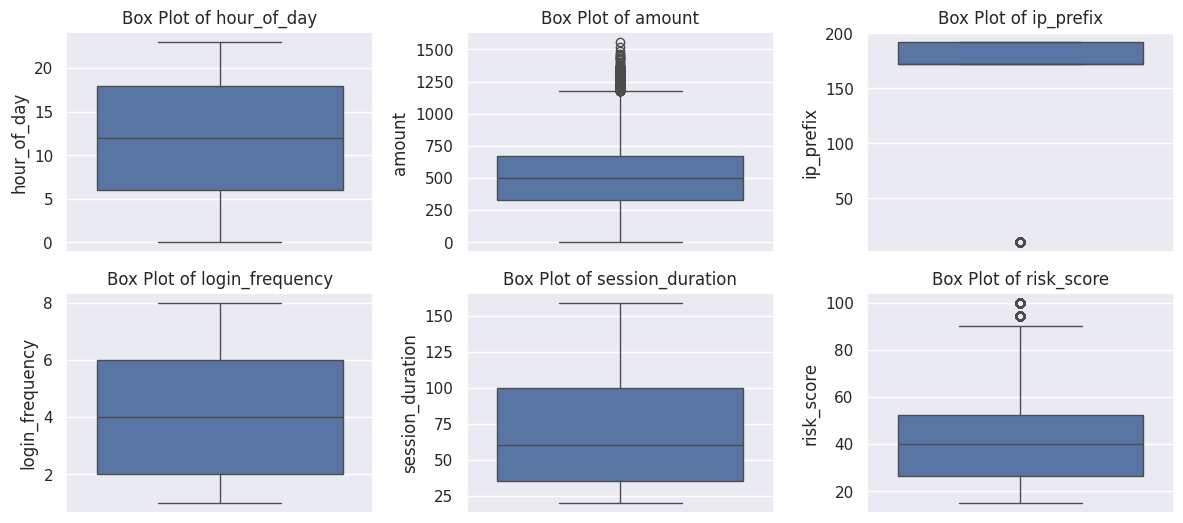

In [ ]:
# Box plot for numeric features
plt.figure(figsize=(12, 8))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Box Plot of {col}')
    plt.tight_layout()

plt.show()


In [ ]:
print(df.head(5))

   hour_of_day      amount transaction_type location_region  ip_prefix  \
0           12  796.949206         transfer          Europe    192.000   
1           19    0.010000         purchase   South America    172.000   
2           16  778.197390         purchase            Asia    192.168   
3            9  300.838358         transfer   South America    172.000   
4           14  775.569344             sale          Africa    172.160   

   login_frequency  session_duration purchase_pattern    age_group  \
0                3                48          focused  established   
1                5                61          focused  established   
2                3                74          focused  established   
3                8               111       high_value      veteran   
4                6               100       high_value      veteran   

   risk_score        anomaly  
0       18.75       low_risk  
1       25.00       low_risk  
2       31.25       low_risk  
3       36

#Task1 - Preprocessing

In [ ]:
# Label encoding categorical columns
categorical_columns = ['location_region', 'purchase_pattern', 'age_group','anomaly']
label_encoder = LabelEncoder()
for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])

In [ ]:
print(df.head(5))

   hour_of_day      amount transaction_type  location_region  ip_prefix  \
0           12  796.949206         transfer                2    192.000   
1           19    0.010000         purchase                4    172.000   
2           16  778.197390         purchase                1    192.168   
3            9  300.838358         transfer                4    172.000   
4           14  775.569344             sale                0    172.160   

   login_frequency  session_duration  purchase_pattern  age_group  risk_score  \
0                3                48                 0          0       18.75   
1                5                61                 0          0       25.00   
2                3                74                 0          0       31.25   
3                8               111                 1          2       36.75   
4                6               100                 1          2       62.50   

   anomaly  
0        1  
1        1  
2        1  
3        1

##Normalizing inconsistent data

In [ ]:
quantitative_attributes = (df.select_dtypes(include=['int64', 'float64']).columns)

for column in quantitative_attributes:
    df[column] = (df[column] - df[column].min()) / (df[column].max() - df[column].min())



In [ ]:
print(df.head(5))

   hour_of_day    amount transaction_type  location_region  ip_prefix  \
0     0.521739  0.511796         transfer             0.50   0.999078   
1     0.826087  0.000000         purchase             1.00   0.889289   
2     0.695652  0.499754         purchase             0.25   1.000000   
3     0.391304  0.193193         transfer             1.00   0.889289   
4     0.608696  0.498066             sale             0.00   0.890167   

   login_frequency  session_duration  purchase_pattern  age_group  risk_score  \
0         0.285714          0.201439               0.0        0.0    0.044118   
1         0.571429          0.294964               0.0        0.0    0.117647   
2         0.285714          0.388489               0.0        0.0    0.191176   
3         1.000000          0.654676               0.5        1.0    0.255882   
4         0.714286          0.575540               0.5        1.0    0.558824   

   anomaly  
0      0.5  
1      0.5  
2      0.5  
3      0.5  
4      1.

In [ ]:
import pandas as pd
import numpy as np

# Load your data
# Replace 'your_dataset.csv' with the path to your dataset file
data = pd.read_csv('/content/metaverse_transactions_dataset.csv')

# Select only numeric columns for analysis
numeric_data = data.select_dtypes(include=[np.number])

# Calculate Q1 (25th percentile) and Q3 (75th percentile) for each numeric column
Q1 = numeric_data.quantile(0.25)
Q3 = numeric_data.quantile(0.75)
IQR = Q3 - Q1

# Apply the IQR method to cap and floor the values
data_capped = numeric_data.copy()  # Create a copy of the numeric data for capping
data_capped = data_capped.apply(lambda x: np.where(x < (Q1[x.name] - 1.5 * IQR[x.name]), Q1[x.name] - 1.5 * IQR[x.name], x), axis=0)
data_capped = data_capped.apply(lambda x: np.where(x > (Q3[x.name] + 1.5 * IQR[x.name]), Q3[x.name] + 1.5 * IQR[x.name], x), axis=0)

# You can check the effect of capping by comparing the min and max values before and after
print("Original Data Description:")
print(numeric_data.describe())
print("\nCapped Data Description:")
print(data_capped.describe())

# Optionally, save the capped dataset to a new CSV file
data_capped.to_csv('capped_dataset.csv', index=False)

# Display the first few rows of the capped dataset
print(data_capped.head())


Original Data Description:
        hour_of_day        amount     ip_prefix  login_frequency  \
count  78600.000000  78600.000000  78600.000000     78600.000000   
mean      11.532634    502.574903    147.644430         4.178702   
std        6.935897    245.898146     69.388143         2.366038   
min        0.000000      0.010000     10.000000         1.000000   
25%        6.000000    331.319966    172.000000         2.000000   
50%       12.000000    500.029500    172.160000         4.000000   
75%       18.000000    669.528311    192.000000         6.000000   
max       23.000000   1557.150905    192.168000         8.000000   

       session_duration    risk_score  
count      78600.000000  78600.000000  
mean          69.684606     44.956722  
std           40.524476     21.775365  
min           20.000000     15.000000  
25%           35.000000     26.250000  
50%           60.000000     40.000000  
75%          100.000000     52.500000  
max          159.000000    100.000000  


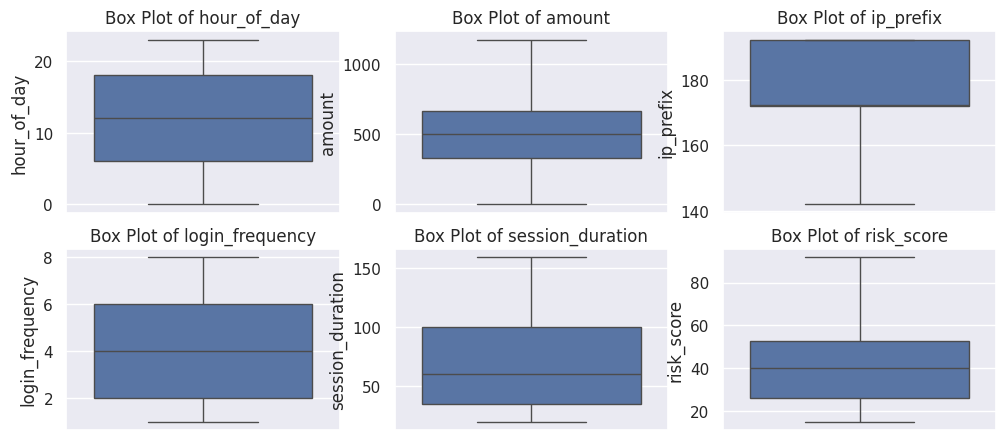

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the cleaned dataset
cleaned_data = pd.read_csv('/content/capped_dataset.csv')

# Select numeric columns
numeric_columns = cleaned_data.select_dtypes(include=[np.number]).columns

# Set the size of the figure
plt.figure(figsize=(12, 8))

# Loop through numeric columns to create box plots
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)  # Adjust 3, 3 based on the number of features
    sns.boxplot(y=cleaned_data[col])
    plt.title(f'Box Plot of {col}')



# Show all plots
plt.show()



#Task 2 – Feature Selection

In [ ]:
df['transaction_type'].value_counts()

,count
transaction_type,
sale,25040
purchase,24940
transfer,22125
scam,3949
phishing,2546


In [ ]:
# Define features and target
X = df.drop('transaction_type', axis = 1)
y = df['transaction_type']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

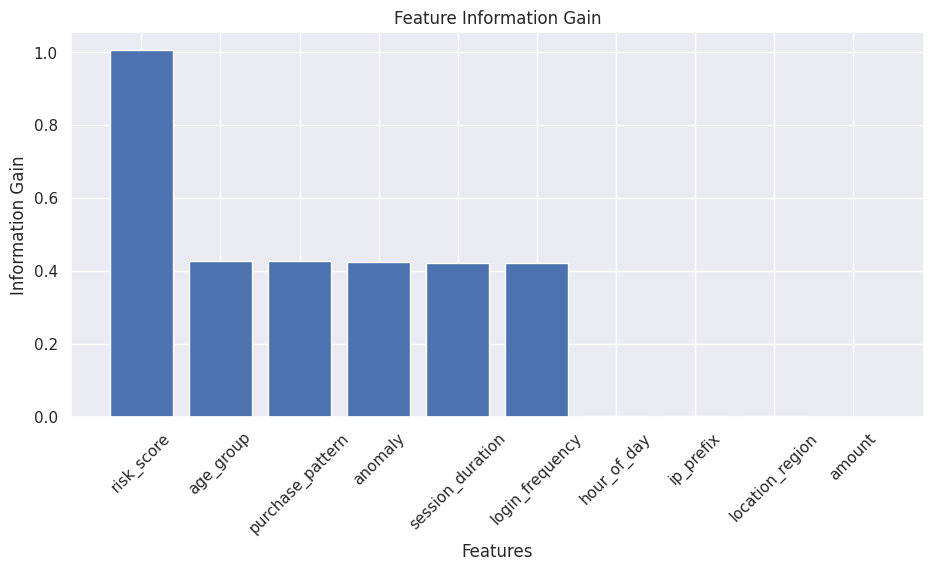

8          risk_score
7           age_group
6    purchase_pattern
9             anomaly
5    session_duration
4     login_frequency
Name: Feature, dtype: object


In [ ]:
# Calculate mutual information
info_gain = mutual_info_classif(X_train, y_train)

# Create a DataFrame for visualization
feature_scores = pd.DataFrame({'Feature': X.columns, 'Information Gain': info_gain})
feature_scores = feature_scores.sort_values(by='Information Gain', ascending=False)  #To make the columns with the highest info gain come first

# Plotting feature importances
plt.figure(figsize=(11, 5))
plt.bar(feature_scores['Feature'], feature_scores['Information Gain'], color='b')
plt.xlabel('Features')
plt.ylabel('Information Gain')
plt.title('Feature Information Gain')
plt.xticks(rotation=45)
plt.show()

# Filter features by information gain, removing all features below the median importance
threshold = 0.2
selected_features = feature_scores[feature_scores['Information Gain'] >= threshold]['Feature']

# Filtered data with selected features
X_filtered = X[selected_features]   #This is the dataframe we'll continue to use from here on (the imp features after checking info gain)
print(selected_features)

#Task 3 – Classification Models

In [ ]:
# Define models and parameters 1
models = {
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100, learning_rate=1.0),
     #'Decision Tree Classifier': DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=4),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=7, weights='distance'),
    'Gaussian Naïve Bayes Classifier': GaussianNB(var_smoothing=1e-9),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5),
     'GBM': GradientBoostingClassifier(
        n_estimators=78,
        max_depth=7,
        min_samples_split=10,
        max_features='sqrt',
        random_state=-2318137449345546192
    ),
    'DRF': H2ORandomForestEstimator(
        ntrees=32,
        max_depth=20,
        min_rows=1,
        nbins=20,
        nbins_top_level=1024,
        nbins_cats=1024
    )
}

In [ ]:
# Define models and parameters 2
models = {
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=150, learning_rate=1.0),
    #'Decision Tree Classifier': DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=7),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=7, weights='uniform'),
    'Gaussian Naïve Bayes Classifier': GaussianNB(var_smoothing=1e-2),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=5)
}

In [ ]:
# Define models and parameters 3
models = {
    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=150, learning_rate=0.5),
    #'Decision Tree Classifier': DecisionTreeClassifier(max_depth=5, min_samples_split=10, min_samples_leaf=7),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=4, weights='distance'),
    'Gaussian Naïve Bayes Classifier': GaussianNB(var_smoothing=1e-3),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=200, random_state=42, min_samples_split=10)
}

In [ ]:
# The best performing parameters
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression


models = {

     'Stacked Ensemble': StackingClassifier(
        estimators=[
            ('gbm', GradientBoostingClassifier(n_estimators=78, random_state=42)),
            ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=4)),
        ],
        final_estimator=LogisticRegression()
    ),

    'GBM': GradientBoostingClassifier(
    n_estimators=78,
    max_depth=7,
    min_samples_split=10,
    max_features='sqrt',
    random_state=42  ),



    'AdaBoost Classifier': AdaBoostClassifier(n_estimators=100, learning_rate=1.0),
   # 'Decision Tree Classifier': DecisionTreeClassifier(max_depth=8, min_samples_split=10, min_samples_leaf=4),
    'KNN Classifier': KNeighborsClassifier(n_neighbors=4, weights='distance'),
    'Gaussian Naïve Bayes Classifier': GaussianNB(var_smoothing=1e-3),
    'Random Forest Classifier': RandomForestClassifier(n_estimators=100, random_state=42, min_samples_split=5),



}

#Task 4 – Model Evaluation

Stacked Ensemble Accuracy (CV): 0.977
Stacked Ensemble Precision (CV): 0.903
Stacked Ensemble Recall (CV): 0.902
Stacked Ensemble F1_score (CV): 0.888
Stacked Ensemble Accuracy (Test): 0.979
Stacked Ensemble Precision (Test): 0.917
Stacked Ensemble Recall (Test): 0.911
Stacked Ensemble F1_score (Test): 0.894
GBM Accuracy (CV): 0.978
GBM Precision (CV): 0.913
GBM Recall (CV): 0.909
GBM F1_score (CV): 0.892
GBM Accuracy (Test): 0.979
GBM Precision (Test): 0.921
GBM Recall (Test): 0.912
GBM F1_score (Test): 0.894


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `ze

AdaBoost Classifier Accuracy (CV): 0.729
AdaBoost Classifier Precision (CV): 0.629
AdaBoost Classifier Recall (CV): 0.635
AdaBoost Classifier F1_score (CV): 0.578


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


AdaBoost Classifier Accuracy (Test): 0.727
AdaBoost Classifier Precision (Test): 0.626
AdaBoost Classifier Recall (Test): 0.635
AdaBoost Classifier F1_score (Test): 0.577


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


KNN Classifier Accuracy (CV): 0.974
KNN Classifier Precision (CV): 0.881
KNN Classifier Recall (CV): 0.885
KNN Classifier F1_score (CV): 0.878
KNN Classifier Accuracy (Test): 0.977
KNN Classifier Precision (Test): 0.893
KNN Classifier Recall (Test): 0.895
KNN Classifier F1_score (Test): 0.887
Gaussian Naïve Bayes Classifier Accuracy (CV): 0.692
Gaussian Naïve Bayes Classifier Precision (CV): 0.733
Gaussian Naïve Bayes Classifier Recall (CV): 0.720
Gaussian Naïve Bayes Classifier F1_score (CV): 0.699
Gaussian Naïve Bayes Classifier Accuracy (Test): 0.692
Gaussian Naïve Bayes Classifier Precision (Test): 0.735
Gaussian Naïve Bayes Classifier Recall (Test): 0.720
Gaussian Naïve Bayes Classifier F1_score (Test): 0.700
Random Forest Classifier Accuracy (CV): 0.978
Random Forest Classifier Precision (CV): 0.918
Random Forest Classifier Recall (CV): 0.912
Random Forest Classifier F1_score (CV): 0.893
Random Forest Classifier Accuracy (Test): 0.979
Random Forest Classifier Precision (Test): 0.

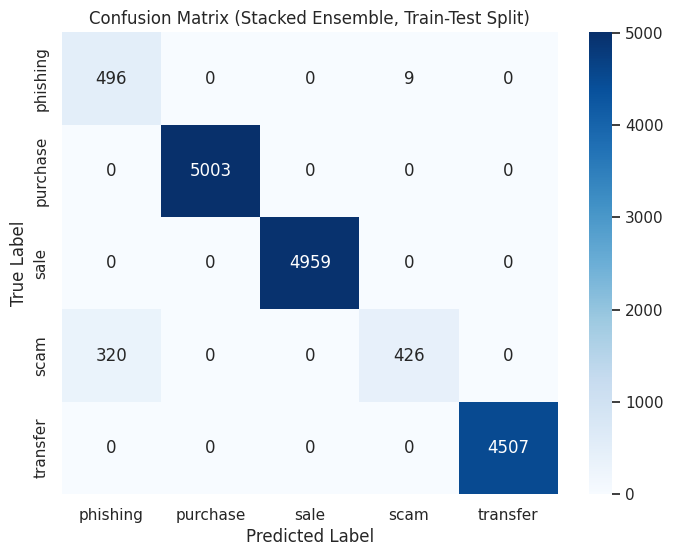

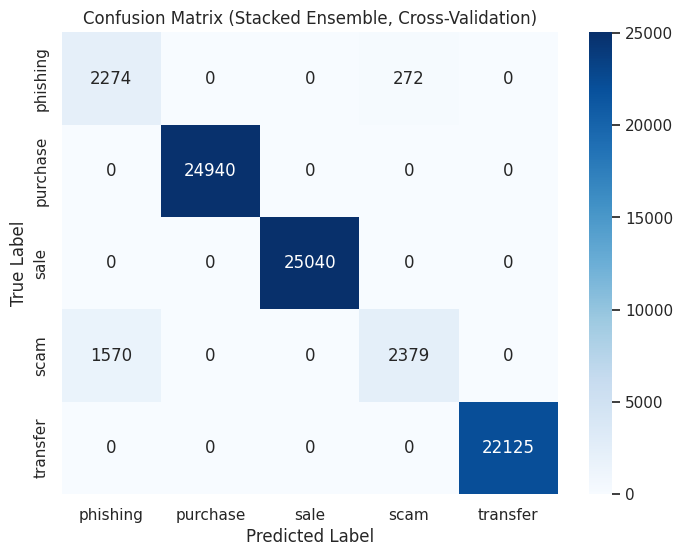

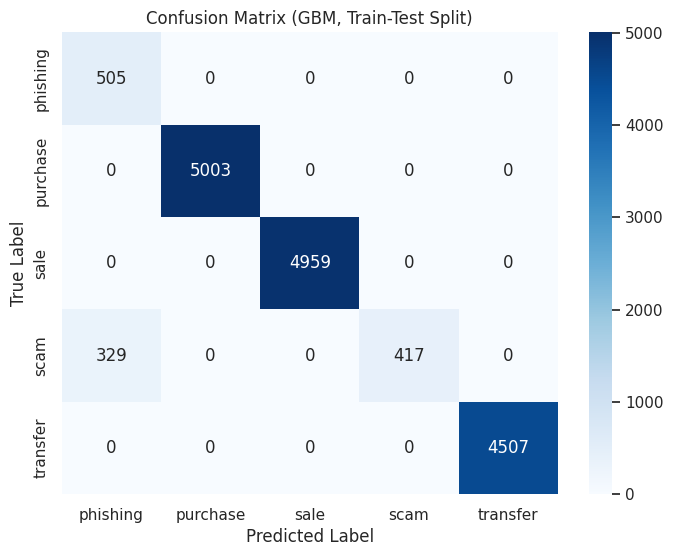

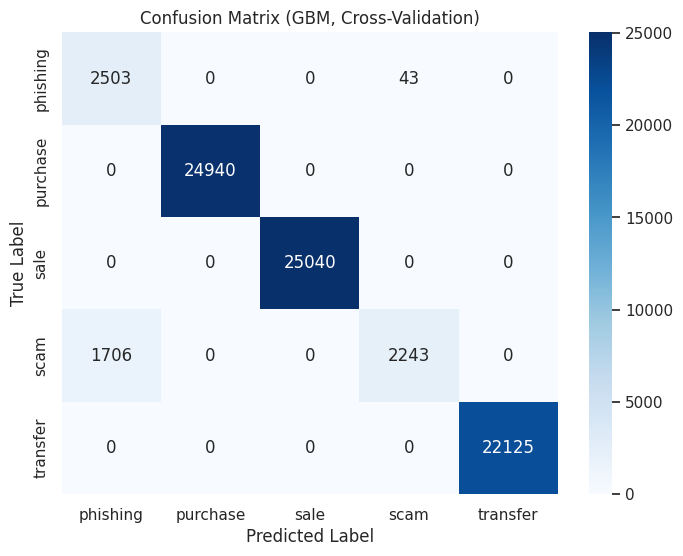

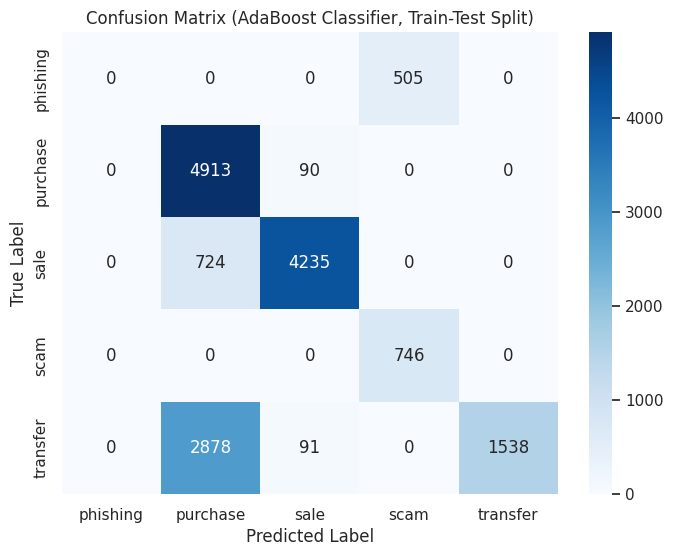

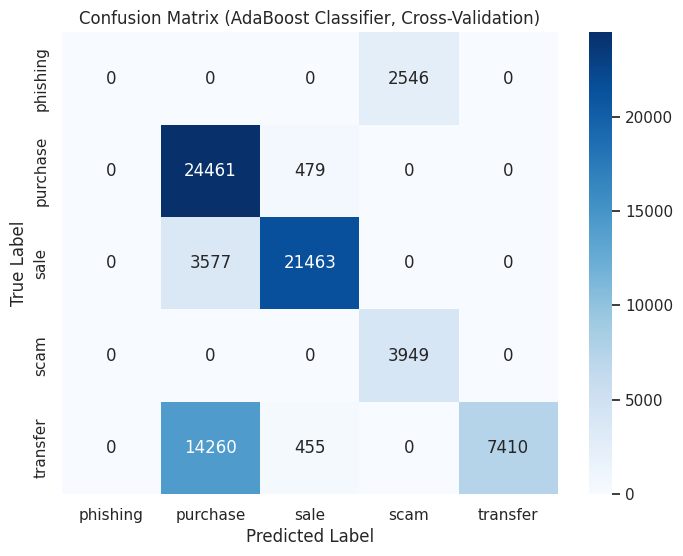

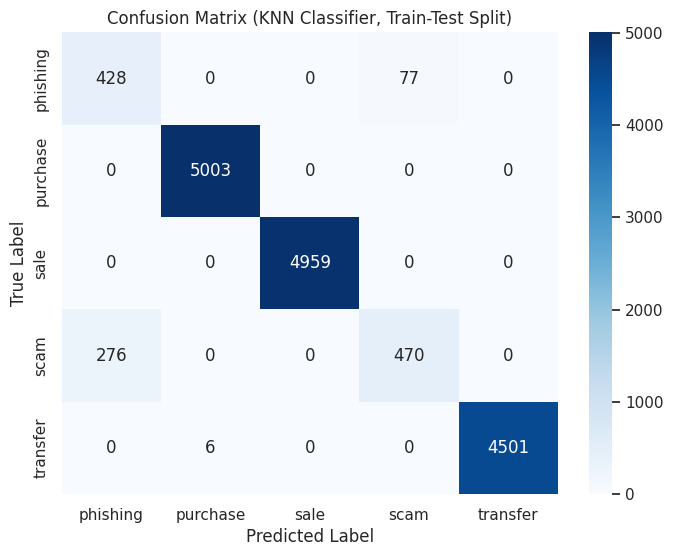

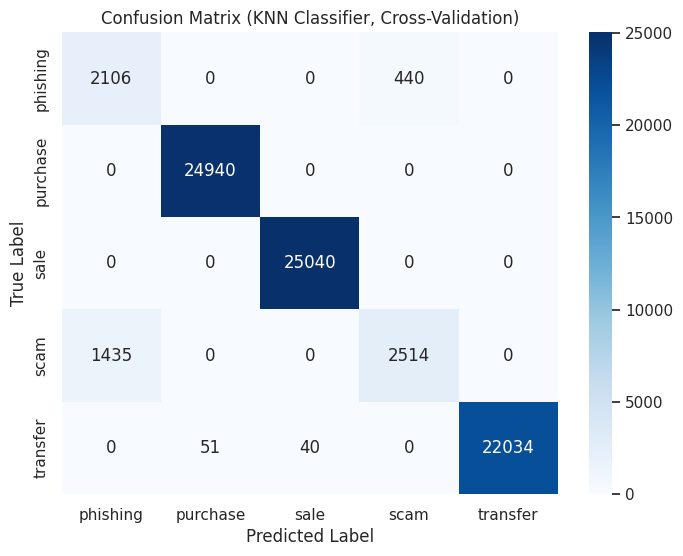

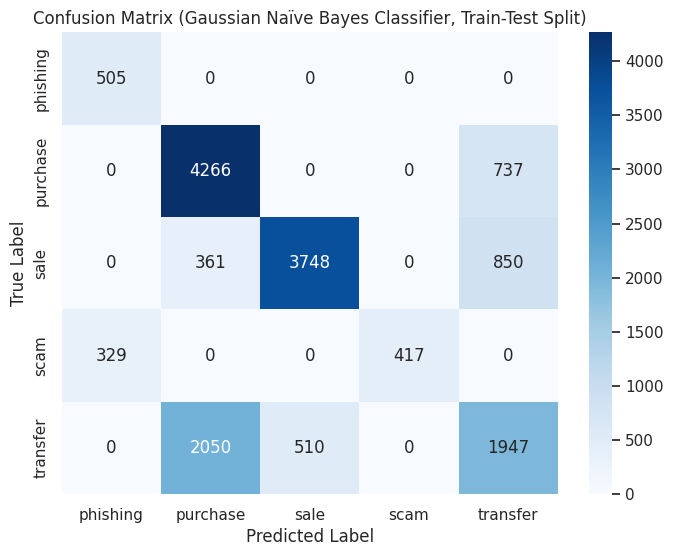

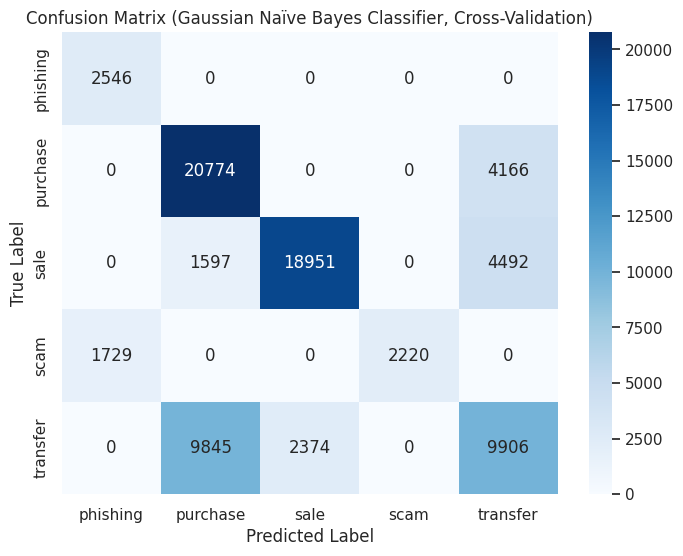

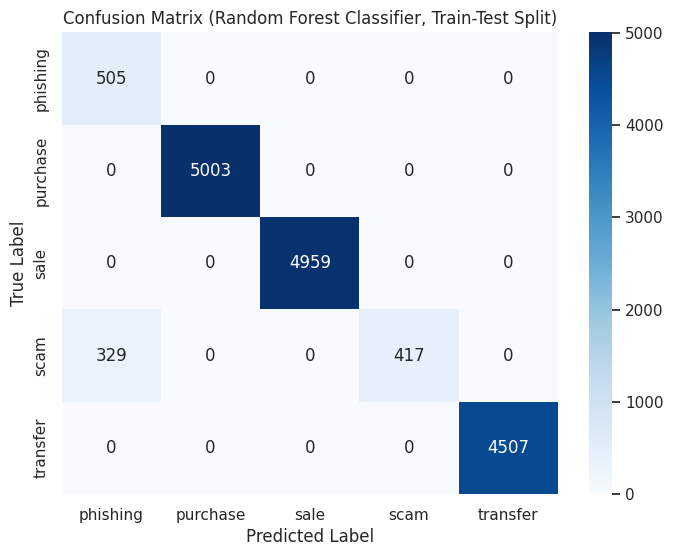

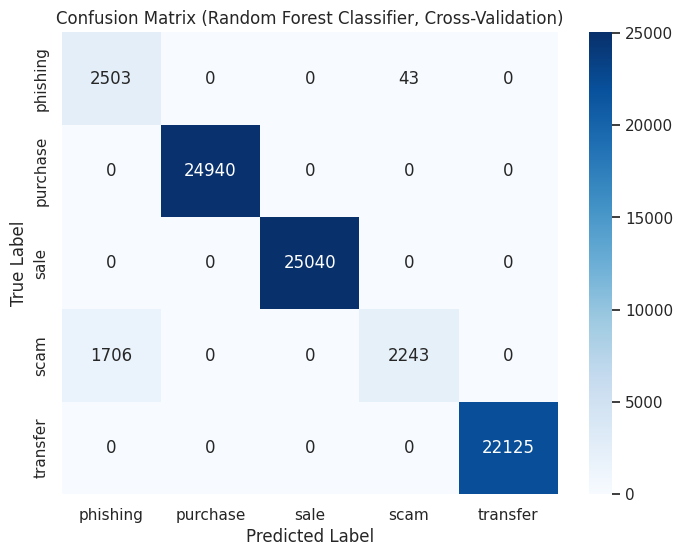

In [ ]:
# Scoring and collecting results
scoring = {
    'Accuracy': 'accuracy',
    'Precision': 'precision_macro',
    'Recall': 'recall_macro',
    'F1_score': 'f1_macro'
}

results = []
confusion_matrices = {}

# Perform evaluations
for name, model in models.items():
    cv_scores = cross_validate(model, X_filtered, y, scoring=scoring, cv=3, return_train_score=False)
    # Iterate through each metric to calculate and print results
    for metric in scoring:
        fold_scores = cv_scores['test_' + metric]
        mean_score = np.mean(fold_scores)
        results.append({
            'Classifier': name,
            'Metric': metric,
            'Score': mean_score,
            'Evaluation Type': 'Cross-Validation'
        })
        print(f"{name} {metric} (CV): {mean_score:.3f}")

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_filtered, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate scores for the train-test split and append to results
    test_scores = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='macro'),
        'Recall': recall_score(y_test, y_pred, average='macro'),
        'F1_score': f1_score(y_test, y_pred, average='macro')
    }
    for metric, score in test_scores.items():
        results.append({
            'Classifier': name,
            'Metric': metric,
            'Score': score,
            'Evaluation Type': 'Train-Test Split'
        })
        print(f"{name} {metric} (Test): {score:.3f}")

    # Generate confusion matrix for train-test split and store it
    confusion_matrices[name] = {
        'Train-Test Split': confusion_matrix(y_test, y_pred)
    }

    # Generate confusion matrix for cross-validation and store it
    cv_cm = np.zeros((len(np.unique(y)), len(np.unique(y))), dtype=int)
    kfold = KFold(n_splits=3, random_state=42, shuffle=True)
    for train_index, test_index in kfold.split(X_filtered, y):
        X_train_cv, X_test_cv = X_filtered.iloc[train_index], X_filtered.iloc[test_index]
        y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train_cv, y_train_cv)
        y_pred_cv = model.predict(X_test_cv)
        cv_cm += confusion_matrix(y_test_cv, y_pred_cv)
    confusion_matrices[name]['Cross-Validation'] = cv_cm

# Display confusion matrices for each model
for name, matrices in confusion_matrices.items():
    for label, cm in matrices.items():
        fig, ax = plt.subplots(1, 1, figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=np.unique(y), yticklabels=np.unique(y), ax=ax)
        ax.set_title(f'Confusion Matrix ({name}, {label})')
        ax.set_ylabel('True Label')
        ax.set_xlabel('Predicted Label')
        plt.show()


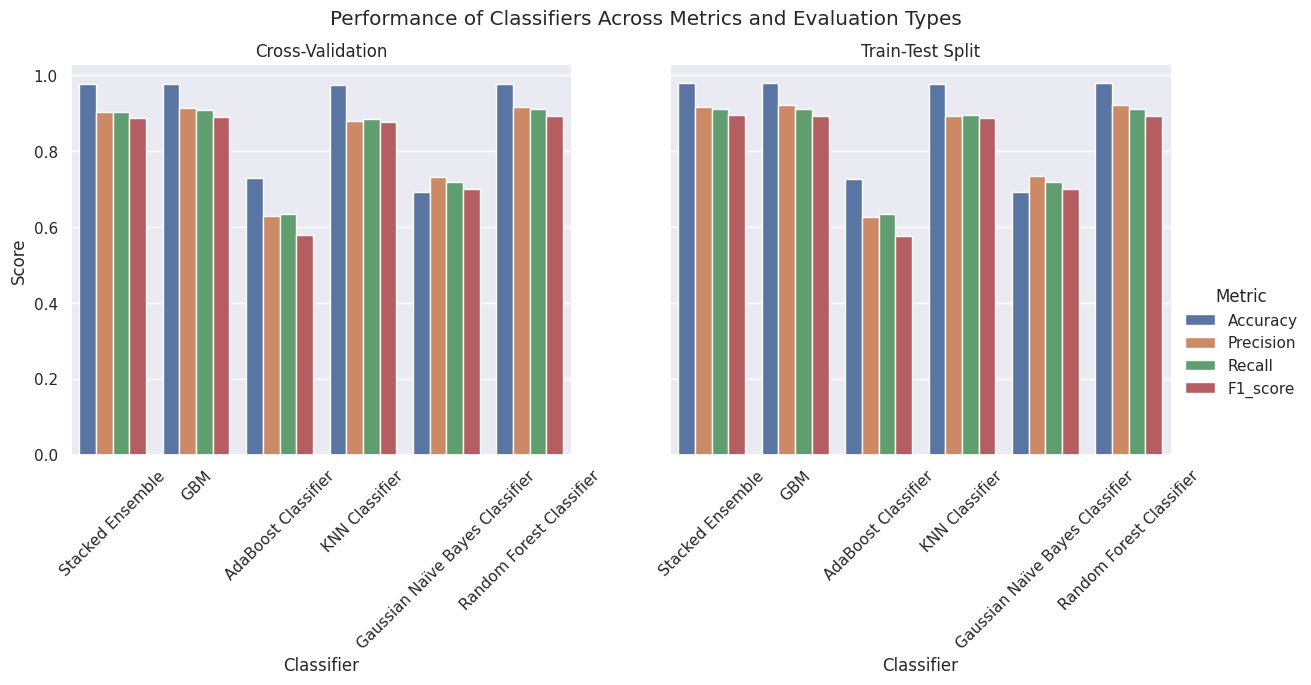

In [ ]:
# Visualization of results
results_df = pd.DataFrame(results)
g = sns.catplot(x='Classifier', y='Score', hue='Metric', col='Evaluation Type', data=results_df, kind='bar', height=5, aspect=1.2)
g.set_xticklabels(rotation=45)
g.set_titles("{col_name}")
g.fig.suptitle('Performance of Classifiers Across Metrics and Evaluation Types', y=1.03)
plt.show()